In [17]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import cv2
import torch.nn as nn
import torchmetrics
import pickle
from PIL import Image
import numpy as np
import albumentations as A
import datetime
import gradio as gr
import shutil

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
class_names = ["unlabelled", "road", "sidewalk", "building", "wall", "fence",
               "pole", "traffic light", "traffic sign", "vegetation",
               "terrain", "sky", "person", "rider", "car", "truck",
               "bus", "train", "motorcycle", "bicycle", "garage", "gate",
               "smallpole"]

In [4]:
colors = [  [  0,  0,  0],
            [128, 64,128],    # 1  # road
            [244, 35,232],    # 2  # sidewalk
            [ 70, 70, 70],    # 3  # building
            [102,102,156],    # 4  # wall
            [190,153,153],    # 5  # fence
            [153,153,153],    # 6  # pole
            [250,170, 30],    # 7  # traffic light
            [220,220,  0],    # 8  # traffic sign
            [107,142, 35],    # 9  # vegatation
            [152,251,152],    # 10 # terrain
            [ 70,130,180],    # 11 # sky
            [220, 20, 60],    # 12 # person
            [255,  0,  0],    # 13 # rider
            [  0,  0,142],    # 14 # car
            [  0,  0, 70],    # 15 # truck
            [  0, 60,100],    # 16 # bus
            [  0, 80,100],    # 17 # train
            [  0,  0,230],    # 18 # motorcycle
            [119, 11, 32],    # 19 # bicycle
            [ 64,128,128],]   # 20 # garage
n_classes = 21

In [5]:
label_colors = dict(zip(range(n_classes), colors))
label_colors

{0: [0, 0, 0],
 1: [128, 64, 128],
 2: [244, 35, 232],
 3: [70, 70, 70],
 4: [102, 102, 156],
 5: [190, 153, 153],
 6: [153, 153, 153],
 7: [250, 170, 30],
 8: [220, 220, 0],
 9: [107, 142, 35],
 10: [152, 251, 152],
 11: [70, 130, 180],
 12: [220, 20, 60],
 13: [255, 0, 0],
 14: [0, 0, 142],
 15: [0, 0, 70],
 16: [0, 60, 100],
 17: [0, 80, 100],
 18: [0, 0, 230],
 19: [119, 11, 32],
 20: [64, 128, 128]}

In [6]:
def plot_losses(train, val):
    plt.plot( train, label="train")
    plt.plot( val, label="val")
    plt.title("Loss Plot")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.xticks(np.arange(0, len(train), step=1), labels = np.arange(1, len(train)+1, step=1))
    plt.legend()
    plt.show()

In [7]:
def plot_metric(train, val):
    plt.plot( train, label="train")
    plt.plot( val, label="val")
    plt.title("IoU Plot")
    plt.ylabel("IoU")
    plt.xlabel("Epoch")
    plt.xticks(np.arange(0, len(train), step=1), labels = np.arange(1, len(train)+1, step=1))
    plt.legend()
    plt.show()

In [8]:
def decode_segmap(temp):
    #convert gray scale to color
    temp=temp.numpy()
    r = temp.copy()
    g = temp.copy()
    b = temp.copy()
    for l in range(0, n_classes):
        r[temp == l] = label_colors[l][0]
        g[temp == l] = label_colors[l][1]
        b[temp == l] = label_colors[l][2]

    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    return rgb

In [9]:
def image_show(data_loader,n):

  #Read Augmented image data
  data_iter = iter(data_loader)
  for i in range(1):
    images,labels = data_iter.next()

  #Convert image from tensor to numpy
  images = images.cpu().detach().numpy()
    
  #Take out n images one by one and display them
  for i in range(n):
    image = np.transpose(images[i],[1,2,0])
    plt.imshow(image, aspect='auto')
    plt.show()

In [10]:
def mask_show(data_loader, n):

  #Read Augmented image data
  data_iter = iter(data_loader)
  for i in range(1):
    images,labels = data_iter.next()

  #Convert image from tensor to numpy
  labels = labels.cpu().detach().numpy()

  #Take out n images one by one and display them
  for i in range(n):
    #label = np.transpose(labels[i], [1,2,0])
    label = labels[i]
    print(label.shape)
    plt.imshow(label, aspect='auto')
    plt.show()

In [11]:
def loading_model(checkpoint, model, optim):
    checkpoint = torch.load(checkpoint)
    model.load_state_dict(checkpoint['model_state'])
    optim.load_state_dict(checkpoint['optim_state'])
    return model, optim, checkpoint['epoch']

In [12]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.255]
)

In [13]:
transformation = transforms.Compose([
                        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                        ])

In [14]:
class KittiDataset(Dataset):
  def __init__(self, image_dir, mask_dir, transform=None):
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.transform = transform
    self.images = os.listdir(image_dir)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    img_path = os.path.join(self.image_dir, self.images[index])
    mask_path = os.path.join(self.mask_dir, self.images[index])
    image = np.array(Image.open(img_path).convert("RGB"))
    mask = np.array(Image.open(mask_path).convert("L"))

    # default size of images is 3 x 1408 x 376
    #try to get albumentations working for better transform applies

    if self.transform is not None:
      Norm = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      tens = transforms.ToTensor()
      blur = transforms.GaussianBlur((7,13),sigma=(0.1, 1.5)) #default value
      sharp = transforms.RandomAdjustSharpness(1.5, 0.5)

      album_transform = A.Compose([
          A.CenterCrop(height=270, width=1011,  always_apply=True),
          ]) #applies to both mask and image

      #update augmentations
      augmentations = album_transform(image=image, mask=mask)
      image = augmentations["image"]
      mask = augmentations["mask"]
      image = tens(image)
      image = sharp(image)
      image = Norm(image)
      image = blur(image)
      mask = np.around(tens(mask), decimals = 4) 

      
      mask = mask.squeeze(0)
      mask[mask == 0.3529] = 1 # road
      mask[mask == 0.4706] = 2 # sidewalk
      mask[mask == 0.2745] = 3 # building
      mask[mask == 0.4235] = 4 # wall
      mask[mask == 0.6431] = 5 # fence
      mask[mask == 0.6000] = 6 # pole 
      mask[mask == 0.6980] = 7 # traffic light
      mask[mask == 0.7647] = 8 # traffic sign
      mask[mask == 0.4667] = 9 # vegatation
      mask[mask == 0.8235] = 10 # terrain
      mask[mask == 0.4627] = 11 # sky
      mask[mask == 0.3294] = 12 # person
      mask[mask == 0.2980] = 13 # rider
      mask[mask == 0.0627] = 14 # car
      mask[mask == 0.0314] = 15 # truck
      mask[mask == 0.1843] = 16 # bus
      mask[mask == 0.2275] = 17 # train
      mask[mask == 0.1020] = 18 # motorcycle
      mask[mask == 0.1804] = 19 # bicycle
      mask[mask == 0.4275] = 20 # garage
      mask[mask < 1] = 0


    
    return image, mask

In [19]:
class Test_KittiDataset(Dataset):
  def __init__(self, image_dir):
    self.image_dir = image_dir
    self.images = os.listdir(image_dir)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    img_path = os.path.join(self.image_dir, self.images[index])

    image = np.array(Image.open(img_path).convert("RGB"))

    Norm = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    tens = transforms.ToTensor()

    image = tens(image)
    image = Norm(image)

    return image

In [20]:
test_2d_root = "data_2d_test"
test_dataset = Test_KittiDataset(image_dir=test_2d_root)
test_data = DataLoader(test_dataset, batch_size=10, shuffle=True, num_workers=1, drop_last=False)

In [ ]:
data_2d_train_root = "data_2d_semantics/KITTI-360/data_2d_raw_train"
mask_2d_train_root = "data_2d_semantics/KITTI-360/semantic_mask_train"

data_2d_val_root = "data_2d_semantics/KITTI-360/data_2d_raw_val"
mask_2d_val_root = "data_2d_semantics/KITTI-360/semantic_mask_val"

In [ ]:
train_dataset = KittiDataset(image_dir=data_2d_train_root, mask_dir=mask_2d_train_root, transform=transformation)

val_dataset = KittiDataset(data_2d_val_root, mask_2d_val_root, transform=transformation)

In [ ]:
train_data = DataLoader(train_dataset, batch_size=8, shuffle=False, num_workers=0, drop_last=True)
val_data = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0, drop_last=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


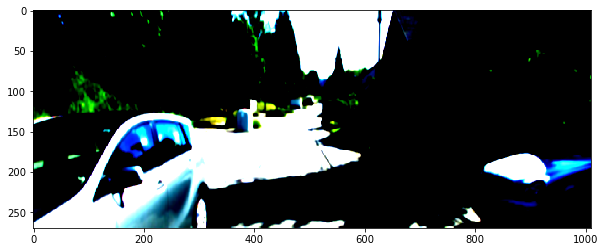

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


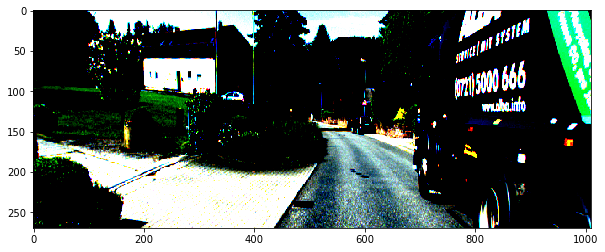

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


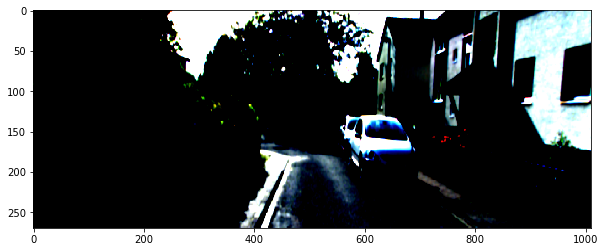

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


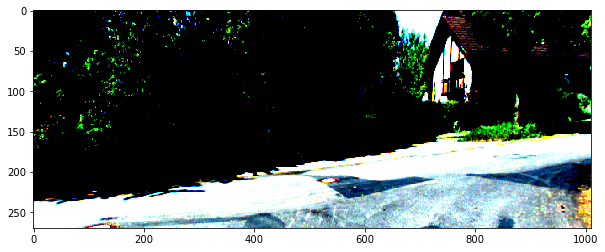

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


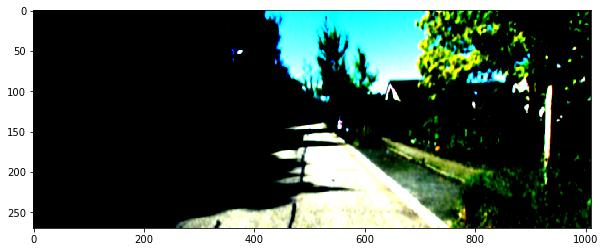

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


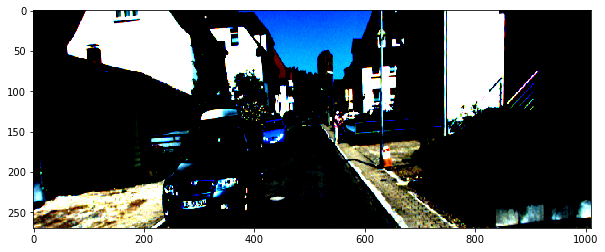

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


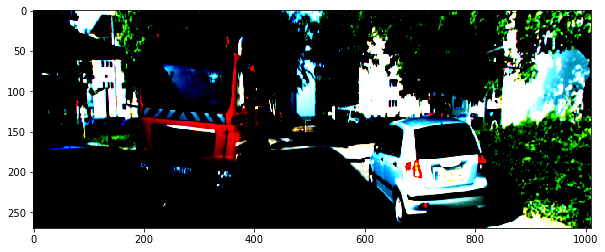

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


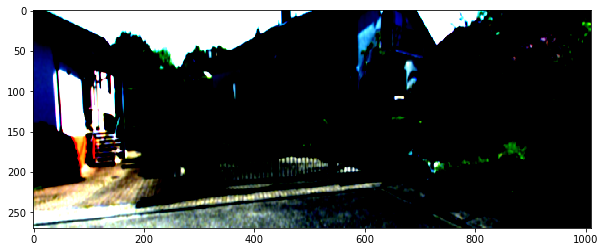

In [ ]:
image_show(train_data, 8)

(270, 1011)


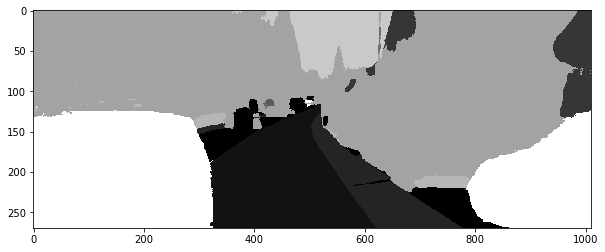

(270, 1011)


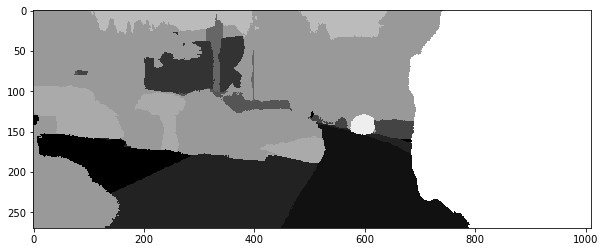

(270, 1011)


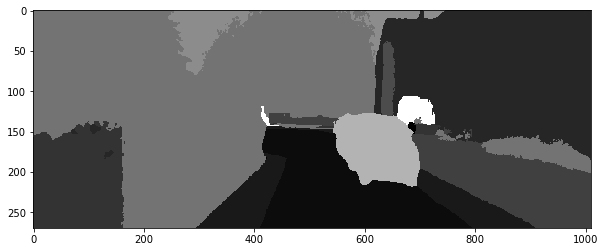

(270, 1011)


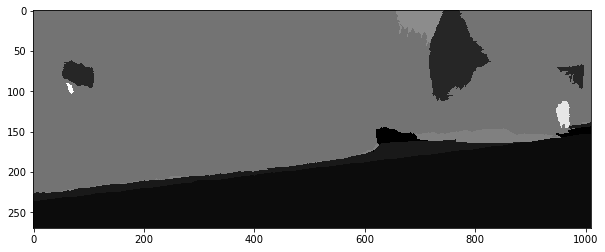

(270, 1011)


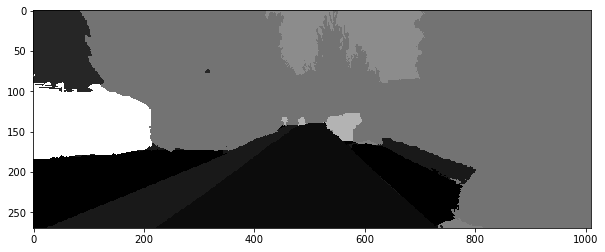

(270, 1011)


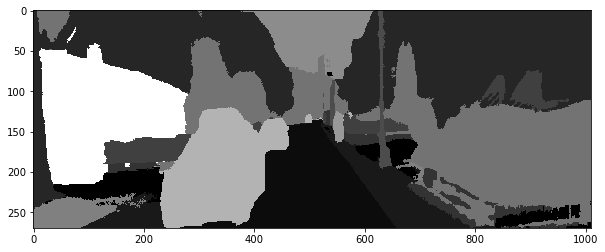

(270, 1011)


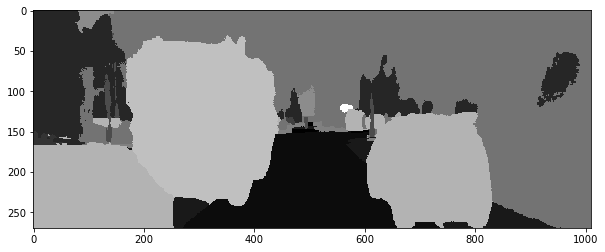

(270, 1011)


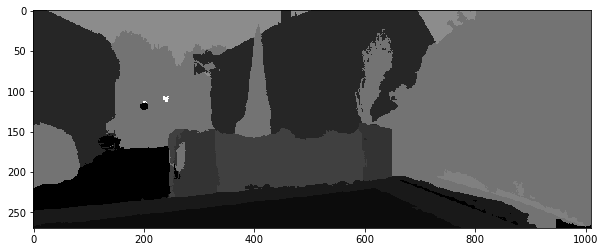

In [ ]:
mask_show(train_data, 8)

In [ ]:
encode_test,seg_encode = train_dataset[3374]
print(encode_test.shape,seg_encode.shape)

torch.Size([3, 270, 1011]) torch.Size([270, 1011])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


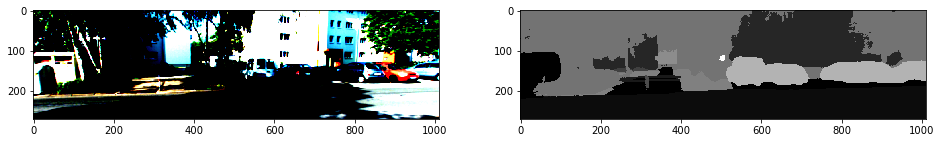

In [ ]:
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(16,8))
ax[0].imshow(encode_test.permute(1, 2, 0))
ax[1].imshow(seg_encode,cmap='gray')

In [ ]:
#class labels
print(torch.unique(seg_encode))
print(len(torch.unique(seg_encode)))

tensor([ 0.,  1.,  2.,  3.,  5.,  6.,  9., 10., 11., 14., 20.])
11


In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
torch.cuda.is_available()

True

In [27]:
!rm -r ~/.cache/torch/hub/

In [28]:
num_epochs = 10
classifier = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True)
classifier = classifier.to(device)
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=0)
classifier, optimizer, epoch_loaded = loading_model("/content/gdrive/MyDrive/final_model.pth", classifier, optimizer)
classifier = classifier.to(device)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
def freeze_layers(model):
  for param in model.parameters():
      param.requires_grad = False
  for param in model.classifier.parameters():
      param.requires_grad = True
  trues = []
  for param in classifier.parameters():
    trues.append(param.requires_grad)
  if (sum(trues) != 23):
    print("Freezing Failed")
    print(sum(trues))
  else:
    print("Freezing Success")

In [ ]:
freeze_layers(classifier)

Freezing Success


In [29]:
classifier = classifier.to(device)

In [ ]:
next(classifier.parameters()).is_cuda

True

In [ ]:
with open("train_loss", "rb") as ap:
  losses = pickle.load(ap)
if (len(losses) != epoch_loaded):
  print("WARNING: # OF LOSSES IS NOT SAME AS EPOCH LOADED! DO NOT RUN FOR LOOP!")
else:
  print("Number of losses = epoch loaded")
with open("val_loss", "rb") as bp:
  val_loss = pickle.load(bp)
with open("train_iou", "rb") as cp:
  train_iou_epochs = pickle.load(cp)
with open("val_iou", "rb") as dp:
  val_iou_epochs = pickle.load(dp)

Number of losses = epoch loaded


In [ ]:
classifier.train()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [ ]:
train_iou = torchmetrics.JaccardIndex(num_classes=n_classes, compute_on_cpu=False).to(device)
val_iou = torchmetrics.JaccardIndex(num_classes=n_classes, compute_on_cpu=False).to(device)

print(f'started at {datetime.datetime.now()}')

for epoch in range(num_epochs):
    #save lists of training info, writes to file
  if (len(losses) >= 0):
    with open("losses", "wb") as fp:
      pickle.dump(losses, fp)
    with open("val_loss", "wb") as fp:
      pickle.dump(val_loss, fp)
    with open("train_iou", "wb") as fp:
      pickle.dump(train_iou_epochs, fp)
    with open("val_iou", "wb") as fp:
      pickle.dump(val_iou_epochs, fp)
  else:
    print("Forgot to import data, or data empty.")
    break;

  # list to compute mean loss per epoch
  temp_loss = []
  temp_val_loss = []

  for batch_idx, (data_, masks_) in enumerate(train_data):

      # Put batch on GPU
      data_ = data_.to(device=device, dtype=torch.float32)
      targets = masks_.to(device=device, dtype=torch.long)

      #backward
      optimizer.zero_grad()

      #forward
      scores = classifier(data_)['out']

      # get loss, iou and append loss to list
      loss = criterion(scores, targets.long())
      train_iou.update(scores,targets)
      temp_loss.append(loss.item())

      #loss.requires_grad = True
      loss.backward()
      # grad descent
      optimizer.step()

      if (batch_idx % 499 == 0):
        print(f'Current loss = {sum(temp_loss) / len(temp_loss)}')
        print(f'Printed at {datetime.datetime.now()}')
        f = open("current_loss.txt", "a")
        f.write(f'Current loss = {sum(temp_loss) / len(temp_loss)}\n')
        f.write(f'Printed at {datetime.datetime.now()}')
        f.close()

  # compute mean loss and mIoU
  train_loss_epoch = sum(temp_loss) / len(temp_loss) #"running loss"
  train_iou_epoch = train_iou.compute()

  # append mean loss and mIoU
  losses.append(train_loss_epoch)
  train_iou_epochs.append(train_iou_epoch)
  current_epoch = epoch_loaded+(epoch+1)
  checkpoint = {"epoch": current_epoch,
              "model_state": classifier.state_dict(),
              "optim_state": optimizer.state_dict()
              }

  model_path = "train_scratch.pth" # Assumes no bad saves will occur
  torch.save(checkpoint, model_path)
  print(f'Train Classifier saved at {datetime.datetime.now()}')

  # forward pass on 
  with torch.no_grad():
    for j, (input, target) in enumerate(val_data):
      input = input.to(device=device, dtype=torch.float32)
      target = target.to(device=device, dtype=torch.long)

      pred = classifier(input)['out']

      v_loss = criterion(pred, target.long())
      val_iou.update(pred, target)
      temp_val_loss.append(v_loss.item())

  val_loss_epoch = sum(temp_val_loss) / len(temp_val_loss)
  val_iou_epoch = val_iou.compute()
  val_loss.append(val_loss_epoch)
  val_iou_epochs.append(val_iou_epoch)


  print(f'Cost at epoch {epoch+1} is {train_loss_epoch}')
  print(f'IoU at epoch {epoch+1} is {train_iou_epoch}')
  print(f'Val Cost at epoch {epoch+1} is {val_loss_epoch}')
  print(f'IoU at epoch {epoch+1} is {val_iou_epoch}')
  checkpoint = {"epoch": current_epoch,
              "model_state": classifier.state_dict(),
              "optim_state": optimizer.state_dict()
              }
  model_path = "val_scratch.pth" # Assumes no bad saves will occur
  torch.save(checkpoint, model_path)
  print(f'Val Classifier saved at {datetime.datetime.now()}')
  print(f'ended at {datetime.datetime.now()}')
  f = open("current_loss.txt", "a")
  f.write(f'Cost at epoch {epoch+1} is {train_loss_epoch}\n')
  f.write(f'Train IOU at epoch {epoch+1} is {train_iou_epoch}\n')
  f.write(f'Val Cost at epoch {epoch+1} is {val_loss_epoch}\n')
  f.write(f'Val IoU at epoch {epoch+1} is {val_iou_epoch}\n')
  f.write(f' Printed at {datetime.datetime.now()}')
  f.close()

  #reset the metrics
  train_iou.reset()
  val_iou.reset()


#save loss values
with open("losses", "wb") as fp:
  pickle.dump(losses, fp)
with open("val_loss", "wb") as fp:
  pickle.dump(val_loss, fp)
with open("train_iou", "wb") as fp:
  pickle.dump(train_iou_epochs, fp)
with open("val_iou", "wb") as fp:
  pickle.dump(val_iou_epochs, fp)

started at 2022-05-13 03:13:51.873853
Current loss = 0.1743091493844986
Printed at 2022-05-13 03:13:53.052992
Current loss = 0.14571405023336412
Printed at 2022-05-13 03:24:19.050880
Current loss = 0.1455130998988648
Printed at 2022-05-13 03:34:39.982568
Current loss = 0.1456649843628241
Printed at 2022-05-13 03:45:04.524026


KeyboardInterrupt: 

## We stop training here because we were unable to tune for better performance and we wanted to output a couple lines of the print statements.

## Additionally we had started training and lost the print that was here but wanted to show that our loss was indeed around this regime.

# Val Data

In [ ]:
classifier.eval()
with torch.no_grad():
    for batch in val_data:
        test_images,seg_test=batch
        output=classifier(test_images.cuda())['out']
        break
print(test_images.shape,seg_test.shape,output.shape)

torch.Size([8, 3, 270, 1011]) torch.Size([8, 270, 1011]) torch.Size([8, 21, 270, 1011])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Predicted mask')

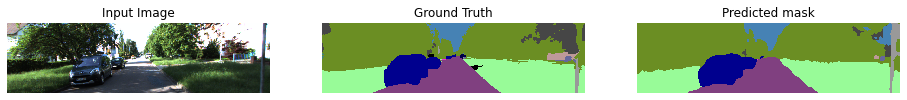

In [ ]:
sample=0
invimg=inv_normalize(test_images[sample])
outputx=output.detach().cpu()[sample]
decoded_ouput=decode_segmap(torch.argmax(outputx,0))
fig,ax=plt.subplots(ncols=3,figsize=(16,50),facecolor='white') 
ax[0].imshow(np.moveaxis(invimg.numpy(),0,2)) # (3,376, 1408)
ax[1].imshow(decode_segmap(seg_test[sample]))
ax[2].imshow(decoded_ouput) # (376, 1408, 3)
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[0].set_title('Input Image')
ax[1].set_title('Ground Truth')
ax[2].set_title('Predicted mask')

# Test Data

In [ ]:
classifier.eval()
with torch.no_grad():
    for batch in test_data:
        test_images=batch
        output=classifier(test_images.cuda())['out']
        break
print(test_images.shape)

torch.Size([10, 3, 376, 1408])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Predicted mask')

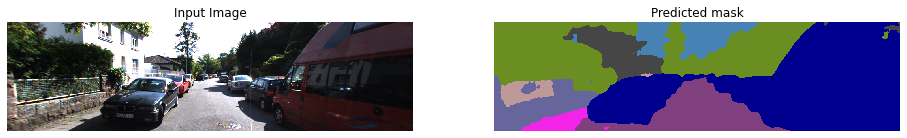

In [ ]:
sample=0
invimg=inv_normalize(test_images[sample])
outputx=output.detach().cpu()[sample]
decoded_ouput=decode_segmap(torch.argmax(outputx,0))
fig,ax=plt.subplots(ncols=2,figsize=(16,50),facecolor='white') 
ax[0].imshow(np.moveaxis(invimg.numpy(),0,2)) # (3,376, 1408)
ax[1].imshow(decoded_ouput) # (376, 1408, 3)
ax[0].axis('off')
ax[1].axis('off')
ax[0].set_title('Input Image')
ax[1].set_title('Predicted mask')

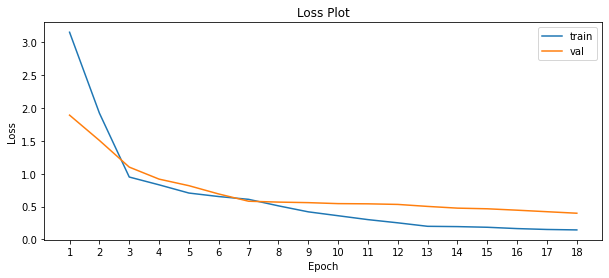

In [ ]:
plot_losses(losses, val_loss)

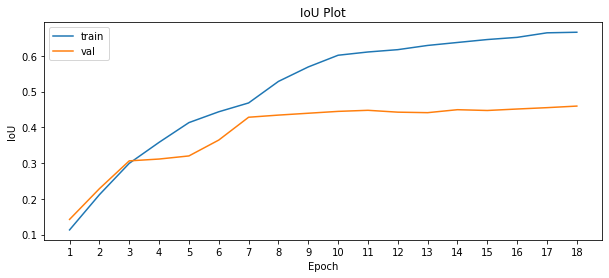

In [ ]:
plot_metric(train_iou_epochs, val_iou_epochs)

In [30]:
#function
def example(image):
  to_image = transforms.ToPILImage()
  img = to_image(image)
  img = np.array(to_image(image).convert("RGB"))
  #img = decode_segmap(img)
  #img = image.reshape((-1, 3, image.shape[0], image.shape[1])),
  Norm = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  rez = transforms.Resize((270,1011))
  tens = transforms.ToTensor()
  img = tens(img)
  img = Norm(img)
  img = rez(img)
  img = img.to(device)
  classifier.eval()
  img = img.unsqueeze(0)
  img = img.float().to(device)
  prediction = classifier(img)['out']
  ex_result = prediction.squeeze().cpu().detach()
  return decode_segmap(torch.argmax(ex_result, 0))

In [32]:
import gradio as gr
title = "Torch Enjoyers 07 Semantic Segmentation"

examples = []
#resize on input
iface = gr.Interface(
        example,
        gr.inputs.Image(shape=(1011, 270), type="numpy"),
        "image",
        title=title,
        examples=examples,
        theme="peach",
        allow_flagging="manual"
                    )

iface.launch(enable_queue=True, debug = True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://44728.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.


(<fastapi.applications.FastAPI at 0x7f4cbd881410>,
 'http://127.0.0.1:7860/',
 'https://44728.gradio.app')